In [14]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import glob
import subprocess
from StringIO import StringIO
from scipy.optimize import curve_fit
%matplotlib inline

In [1310]:
# get path/file/strain names
ref_gen_path = glob.glob('/Users/fridolin/Desktop/arbeit/IFOM/sequencing/data/ref_genomes/*.fa*')
ref_index = glob.glob('/Users/fridolin/Desktop/arbeit/IFOM/sequencing/data/ref_genomes/*.fai')[0]
bams1 = glob.glob('/Users/fridolin/Desktop/arbeit/IFOM/sequencing/data/sequences_2_bam_files/*.bam')
bams2 = glob.glob('/Users/fridolin/Desktop/arbeit/IFOM/sequencing/data/novogene_bam_files/*.bam')
bams = bams1+bams2

In [1309]:
def get_coverage(bams, ref_index, blocksize=10000, checkbams=False, outfile=None):
    """Generate coverage from bam files."""
    bams_tested = bams[:]
    # removing bams that cannot be uncompressed -- not ideal, could replace it at some point
    if checkbams:
        for i,bam in zip(range(len(bams)), bams):
            try:
                print 'checking file '+bam+'...'
                subprocess.check_output('gunzip -t '+bam, shell=True)
            except:
                print 'error in file '+bam+'\nwill be removed from list of .bam files'
                bams_tested.pop(i)
                continue 
            print 'valid'
    bam_arg = ' '.join(bams_tested)
    file_names = [os.path.basename(b) for b in bams_tested]
    sample_names = [f.split('.')[0] for f in file_names]
    # create empty data frame to collect results
    df = pd.DataFrame(columns=['chr','pos']+sample_names)
    # read info about chromosomes from ref index file
    df_index = pd.read_csv(ref_index, sep='\t', names=['chr', 'length'], usecols=[0,1])
    # sort by chromosome length
    df_index = df_index.sort_values(by='length', ascending=False)
    # get depth for all samples by looping over chromosomes
    for i,r in df_index.iterrows():
        chr_i = r.chr
        length_i = r.length
        cmd = 'samtools depth '+ bam_arg +' -r '+chr_i
        try:
            depth_i_str = subprocess.check_output(cmd, shell=True)
        except subprocess.CalledProcessError:
            print 'Samtools produced an error processing chromosome '+chr_i+'. Consider re-running with check_bams=True'
            raise
        depth_i_file = StringIO(depth_i_str) # enable samtools output to be read as file by pandas
        df_i = pd.read_csv(depth_i_file, sep='\t', names=['chr', 'pos']+sample_names) # data frame for chr i     
        blocks_i = pd.Series(np.repeat(range(int(length_i/blocksize)), blocksize)) # divide chr into blocks 
        blocks_i.append(pd.Series(np.repeat(blocks_i.iloc[-1],length_i-len(blocks_i))), ignore_index=True) # assign leftover to last block
        grouped = df_i.groupby(by=blocks_i) # group by blocks
        df_i_med = grouped.agg('median') # calculate blockwise median (also for position)
        df_i_med.insert(loc=0, column='chr', value=chr_i) # insert chr column
        df = df.append(df_i_med, ignore_index=True) # append to results data frame
    if outfile is not None:
        df.to_csv(outfile, sep='\t') # save results as csv
    return df

Text(0,0.5,'coverage')

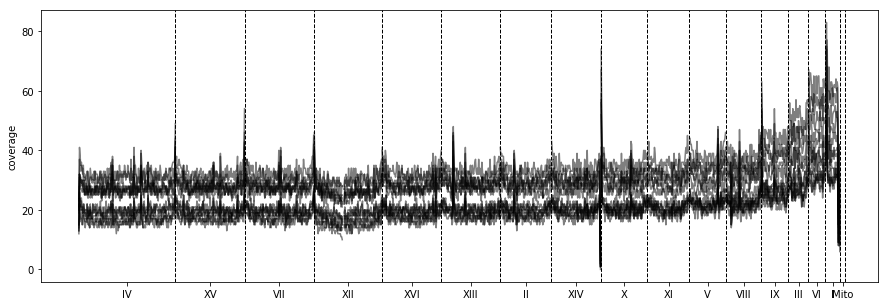

In [828]:
fig, ax = plt.subplots(1,1,figsize=(15,5),sharex=True,sharey=True)
sample_names = df_OL.columns[2::]
for i,s in zip(range(len(sample_names)), sample_names):
    df_plot = df_OL[['chr', 'pos', s]]
    df_plot.reset_index(level=0, inplace=True)
    df_plot.groupby(by='chr', sort=False, as_index=False).plot(y=s, ax=ax, legend=False,color='k',alpha=0.5)
for x in df_plot.groupby('chr', sort=False).max()['index']:
    ax.axvline(x=x,lw=1,color='k',ls='--')
xtick_pos = df_plot.groupby('chr', sort=False).median()['index']
xtick_lab = df_plot.chr.unique()
ax.set_xticks(xtick_pos)
ax.set_xticklabels(xtick_lab)
ax.set_ylabel('coverage')

In [829]:
def exp_fit(x, a, b, c):
    return a * np.exp(-b * x) + c

In [1366]:
def remove_outliers(df, low=0.5, high=3):
    df_OL = df.copy()
    sample_names = df.columns[2:]
    higher = df[sample_names].div(df.groupby('chr')[sample_names].transform(lambda x: x.median()))<high
    lower = df[sample_names].div(df.groupby('chr')[sample_names].transform(lambda x: x.median()))>low
    df_OL[sample_names] = df[sample_names].where(higher & lower)
    return df_OL

In [1405]:
df_corr.head()

,chr,pos,b5_S11_L001,b7_S13_L001,a8_S17_L001,b10_S20_L001,a12_S23_L001,b12_S24_L001,b1_S2_L001,f4_S10_L001,...,4029,150c,b12,c7,t238sc,b4,150e,t238sa,t238sf,a10
0,IV,5000.5,22.0,17.0,21.0,5.0,21.0,21.0,19.0,18.0,...,4.0,9.0,11.0,11.0,8.0,11.0,8.0,14.0,9.0,25.0
1,IV,15000.5,35.0,30.0,32.0,6.0,27.0,30.0,31.0,26.0,...,31.0,31.0,17.0,21.0,34.0,18.0,30.0,57.0,46.0,31.0
2,IV,25000.5,32.0,30.0,27.0,5.0,24.0,24.0,25.0,27.0,...,26.0,26.0,14.0,16.0,32.0,13.0,30.0,53.0,36.0,21.0
3,IV,35000.5,34.0,26.0,29.0,4.0,26.0,22.0,26.0,24.0,...,28.0,26.0,12.0,15.0,31.0,15.0,25.0,48.0,38.0,21.0
4,IV,45000.5,33.0,24.0,25.0,4.0,23.0,25.0,25.0,23.0,...,26.0,28.0,14.0,16.0,30.0,12.0,27.0,51.0,35.0,22.0


Text(0.5,0,'chromosome size (x10000)')

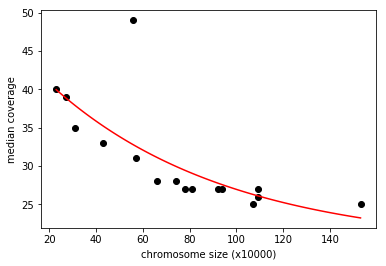

In [1473]:
df_corr = df_all.copy()
for s in ['b5_S11_L001']:# sample_names[0:1]:
    df_corr = df_corr[df_corr.chr!='Mito']    
    x = df_corr[['chr','pos',s]].groupby(by='chr', sort=False).count().pos
    y = df_corr[['chr','pos',s]].groupby(by='chr', sort=False).agg('median')[s]
    x = x[~y.isna()]
    y = y[~y.isna()]
    popt, pcov = curve_fit(exp_fit, x, y, bounds=(0, [500., 1., 50.]))
    y_fit = exp_fit(x, *popt)
    df_corr[s] = df_corr[s].sub(df_corr.chr.map(y_fit))
    plt.scatter(x,y, color='k')
    x_plot = np.linspace(np.min(x),np.max(x),101)
    y_plot = exp_fit(x_plot, *popt)
    plt.plot(x_plot,y_plot, color='r')
#plt.ylim([0,10])
plt.ylabel('median coverage')
plt.xlabel('chromosome size (x10000)')
#plt.savefig('length_correction.pdf')

In [1500]:
def correct_XII(df):
    df_corr = df.copy()
    sample_names = df_corr.columns[2::]    
    for s in sample_names:
        s_XII = df_corr[df_corr.chr=='XII'][s]
        s_XII[s_XII-s_XII.median()>5*s_XII.std()].sum()

In [1511]:
def correct_length_bias(df, drop_mito=True, corr_OL=True, corr_XII=True):
    df_corr = df.copy()
    if drop_mito:
        df_corr = df_corr[df_corr.chr!='Mito']
    sample_names = df_corr.columns[2::]    
    for s in sample_names:
        x = df_corr[['chr','pos',s]].groupby(by='chr', sort=False).count().pos
        y = df_corr[['chr','pos',s]].groupby(by='chr', sort=False).agg('median')[s]
        x_nona = x[~y.isna()]
        y_nona = y[~y.isna()]
        if corr_XII:
            s_XII = df_corr[df_corr.chr=='XII'][s]
            x.XII += s_XII[s_XII-s_XII.median()>5*s_XII.std()].sum()
        popt, pcov = curve_fit(exp_fit, x_nona, y_nona, bounds=(0, [500., 1., 50.]))
        y_fit = exp_fit(x, *popt)
        if corr_OL:
            res = y_fit-y
            OL = np.abs(res-res.mean())>1.5*res.std()
            x_noOL = x_nona[~OL]
            y_noOL = y_nona[~OL]
            popt, pcov = curve_fit(exp_fit, x_noOL, y_noOL, bounds=(0, [500., 1., 50.]))
            y_fit = exp_fit(x, *popt)
        df_corr[s] = df_corr[s].div(df_corr.chr.map(y_fit))
    return df_corr

In [1426]:
df_all = pd.read_csv('../results/coverage_all2.csv', index_col=0,sep='\t')
cols_new = list(df_all.columns)
cols_new.pop(13)
to_drop = cols_new[-1]
df_all.drop([to_drop],axis=1,inplace=True)
df_all = df_all[df_all.chr!='Mito']
df_all.columns = cols_new
df_sorted = df_all.iloc[:,2:]
df_sorted = pd.concat([df_all.iloc[:,0:2], df_all.iloc[:,2:].sort_index(axis=1)], axis=1)

In [1512]:
df_corr = df_sorted.copy()
df_corr = correct_length_bias(df_corr, drop_mito=True)
df_corr = remove_outliers(df_corr,high=1.5,low=0.7)
df_corr = correct_smile(df_corr)
df_corr = normalize_coverage(df_corr)

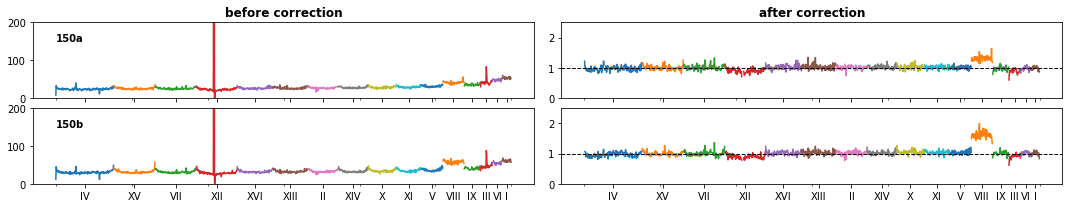

In [1513]:
sample_names = df_corr.columns[2:4]
fig, ax = plt.subplots(len(sample_names),2,figsize=(15,1.5*len(sample_names)),sharex=True)
for i,s in zip(range(len(sample_names)), sample_names):
    df_plot_before = df_all[['chr', 'pos', s]].copy()
    df_plot_before.reset_index(level=0, inplace=True)    
    df_plot_before.groupby(by='chr', sort=False, as_index=False).plot(y=s, ax=ax[i,0], legend=False)    
    df_plot_after = df_corr[['chr', 'pos', s]]
    df_plot_after.reset_index(level=0, inplace=True)
    df_plot_after.groupby(by='chr', sort=False, as_index=False).plot(y=s, ax=ax[i,1], legend=False)
    ax[i,0].text(0,150,s,fontweight='bold')
    ax[i,0].set_ylim([0,200])
    ymin = np.min([0, np.min(df_plot_after[s])])
    ymax = np.max([2.5, np.max(df_plot_after[s])])    
    ax[i,1].set_ylim([ymin,ymax])
    ax[i,1].axhline(y=1, color='k', ls='--', lw=1)
    ax[i,0].set_xticks([])
xtick_pos = df_plot_before.groupby('chr', sort=False).median()['index']
xtick_lab = df_plot_before.chr.unique()
ax[-1,0].set_xticks(xtick_pos)
ax[-1,0].set_xticklabels(xtick_lab)
ax[-1,1].set_xticks(xtick_pos)
ax[-1,1].set_xticklabels(xtick_lab)
ax[0,0].set_title('before correction', fontweight='bold')
ax[0,1].set_title('after correction', fontweight='bold')
plt.tight_layout(h_pad=0)
plt.savefig('../results/coverage_20181106_20190225.pdf')

In [1510]:
df_corr[df_corr.chr=='VIII']

,chr,pos,150a,150b,150c,150d,150e,150f,4028,4029,...,e4_S9_L001,f4,f4_S10_L001,h7_S16_L001,t238sa,t238sb,t238sc,t238sd,t238se,t238sf
1020,VIII,5000.5,NaN,NaN,0.948167,NaN,1.034152,NaN,NaN,0.867626,...,NaN,NaN,NaN,NaN,0.957970,1.033437,0.974348,0.936356,0.921852,0.997503
1021,VIII,15000.5,NaN,NaN,1.027968,NaN,1.047240,NaN,NaN,1.118675,...,NaN,NaN,NaN,NaN,1.041157,1.041823,1.078025,0.977582,1.041800,0.966076
1022,VIII,25000.5,NaN,NaN,1.044468,NaN,1.092287,NaN,NaN,1.020978,...,NaN,NaN,NaN,NaN,1.069223,1.181281,0.927329,1.084979,0.938336,0.977862
1023,VIII,35000.5,NaN,NaN,1.027689,NaN,1.040379,NaN,NaN,0.921632,...,NaN,NaN,NaN,NaN,0.927121,0.969869,0.902745,0.928589,0.946312,0.989468
1024,VIII,45000.5,NaN,NaN,0.942418,NaN,1.052513,NaN,NaN,1.034779,...,NaN,NaN,NaN,NaN,0.953973,1.021434,0.877454,1.036728,1.030419,1.000872
1025,VIII,55000.5,NaN,NaN,0.956422,NaN,1.031149,NaN,NaN,0.933652,...,NaN,NaN,NaN,NaN,0.961694,0.894527,0.884214,0.944006,0.961664,0.920045
1026,VIII,65000.5,NaN,NaN,0.970214,NaN,0.975169,NaN,NaN,0.939381,...,NaN,NaN,NaN,NaN,1.007960,0.945693,0.923764,1.087308,1.007775,0.929979
1027,VIII,75000.5,NaN,NaN,0.948621,NaN,1.053417,NaN,NaN,0.981256,...,NaN,NaN,NaN,NaN,0.937395,0.997252,0.996798,0.992788,1.015176,1.010137
1028,VIII,85000.5,NaN,NaN,0.961402,NaN,1.132760,NaN,NaN,1.023334,...,NaN,NaN,NaN,NaN,1.101480,1.003546,1.003600,0.965469,1.061639,0.996527
1029,VIII,95000.5,NaN,NaN,0.901729,NaN,1.005148,NaN,NaN,1.065582,...,NaN,NaN,NaN,NaN,0.990213,1.009598,0.976469,0.972129,1.029193,0.934235


In [1022]:
def normalize_coverage(df):
    df_norm = df.copy()
    df_norm.iloc[:,2::] = df_norm.iloc[:,2::].div(df_norm.iloc[:,2::].median())
    return df_norm

In [1398]:
df_all[df_all[s]==df_all[s].max()]

,chr,pos,b5_S11_L001,b7_S13_L001,a8_S17_L001,b10_S20_L001,a12_S23_L001,b12_S24_L001,b1_S2_L001,f4_S10_L001,...,4029,150c,b12,c7,t238sc,b4,150e,t238sa,t238sf,a10
417,XII,465000.5,2323.0,1915.0,1426.0,200.0,1453.0,1373.0,2256.0,1468.0,...,1504.0,905.0,671.0,1084.0,1642.0,846.5,971.0,2782.0,1947.0,809.0


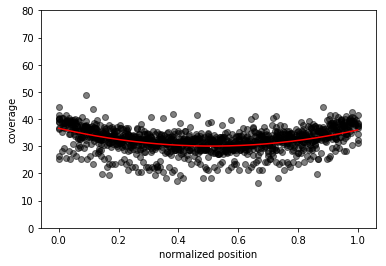

In [1300]:
df_norm = df_all.copy()
df_norm = remove_outliers(df_norm,low=0.2,high=1.2)
df_norm = correct_length_bias(df_norm)
df_norm['norm_pos'] = df_norm.groupby('chr').transform(lambda x: np.linspace(0,1,x.shape[0])).pos
for s in ['3915']:
    x = df_norm.sort_values(by='norm_pos').norm_pos
    y = df_norm.sort_values(by='norm_pos')[s]
    x = x[~y.isna()]
    y = y[~y.isna()]    
    popt, pcov = curve_fit(quad_fit, x, y, bounds=([0.,-1000,0], [1., 100., 100.]))
    y_fit = quad_fit(df_norm.norm_pos, *popt)
    y_plot = quad_fit(x, *popt)
    plt.scatter(x,y,color='k',alpha=0.5)
    plt.plot(x,y_plot,color='r')
plt.xlabel('normalized position')
plt.ylabel('coverage')
plt.ylim([0,80])
plt.savefig('smile_correction.pdf')

In [1400]:
def quad_fit(x, x0, a, b):
    return a * (x-x0)**2 + b

def correct_smile(df):
    df_norm = df.copy()
    sample_names = df_norm.columns[2:]
    df_norm['norm_pos'] = df_norm.groupby('chr').transform(lambda x: np.linspace(0,1,x.shape[0])).pos
    for s in sample_names:
        x = df_norm.sort_values(by='norm_pos').norm_pos
        y = df_norm.sort_values(by='norm_pos')[s]
        x = x[~y.isna()]
        y = y[~y.isna()]          
        popt, pcov = curve_fit(quad_fit, x, y, bounds=([0.,-1000,0], [1., 1000., 1000.]))
        y_fit = quad_fit(df_norm.norm_pos, *popt)
        df_norm[s] = df_norm[s].div(y_fit)
    df_norm.drop('norm_pos',axis=1,inplace=True)
    return df_norm

In [30]:
# function to generate coverage per bin from pileup file

def get_coverage_from_bam(bams, ref, blocksize=None):
    """Generate coverage from bam files."""    
    cmd = 'samtools mpileup -B -Q 30 -f'+' '+ref+' '+' '.join(bams)
    file_names = [os.path.basename(b) for b in bams]
    samples = [f.split('.')[0] for f in file_names]
    with open('./temp','w') as temp:
        out = subprocess.call(cmd, stdout=temp, shell=True)
    if blocksize is None:
        blocksize = 10000
    df = get_coverage('./temp', samples, blocksize)
    return df

def get_coverage(pileup, samples, region):
    """Generate the coverage from pileup file with blocks of length = blocksize."""
    blocksize = 10000
    pos_count = 0
    n_samples = len(samples)
    df = pd.DataFrame()
    with open(pileup, 'r') as f:
        while True:
            array_temp = np.zeros((blocksize, n_samples+1))
            for i in range(blocksize):
                line = f.readline().split()
                if not line:
                    break
                if i==0:
                    chr0 = line[0]
                if line[0]!=chr0:
                    array_temp = array_temp[:i]
                    break
                array_temp[i,0] = pos_count
                array_temp[i,1:n_samples+1] = [int(line[3*(s+1)]) for s in range(n_samples)]
                pos_count+=1
            d1 = {'chr': chr0, 'pos': np.median(array_temp[:,0])}
            d2 = {samples[s]: np.median(array_temp[:,s+1]) for s in range(n_samples)}
            df = df.append(dict(d1.items()+d2.items()), ignore_index=True)
            if not line:
                break
    return df

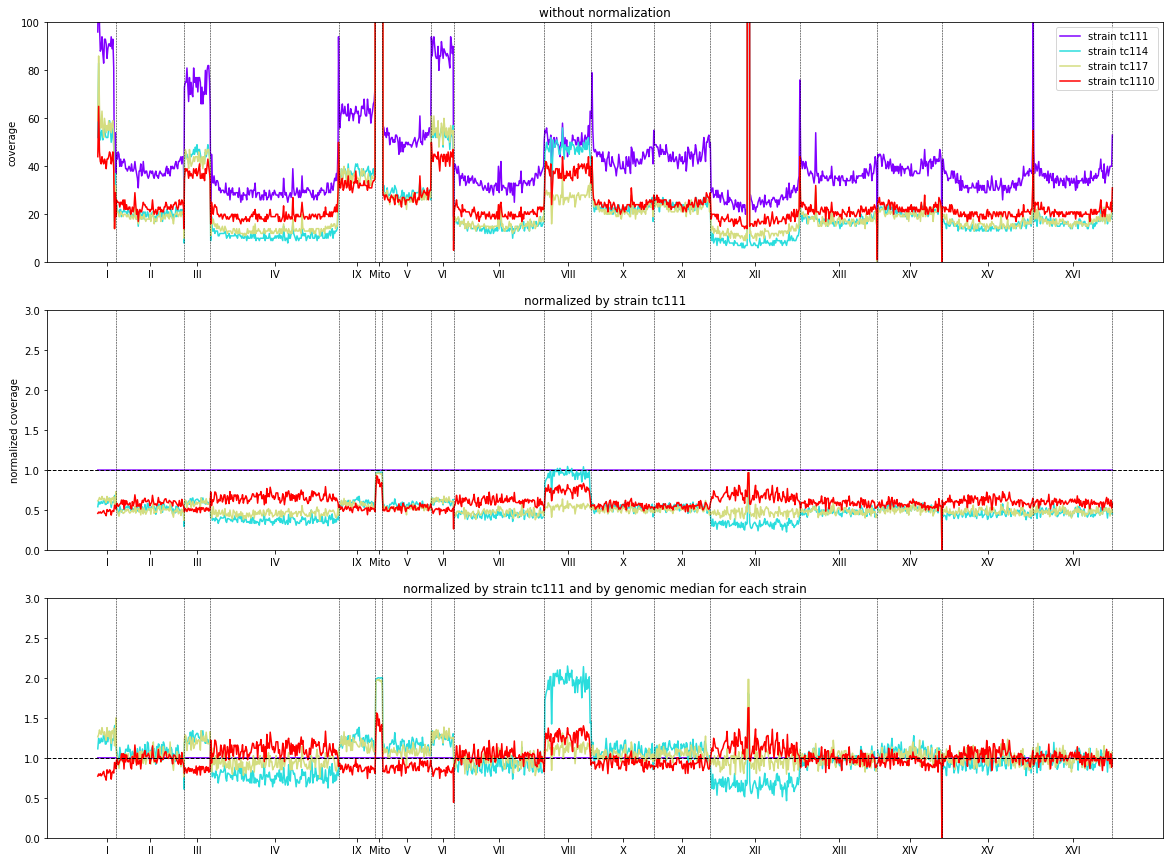

In [27]:
# plot absolute and normalized coverage
df = get_coverage('/Volumes/milano/sequencing/round2/pileup_round2.txt', ['tc111', 'tc114', 'tc117', 'tc1110'], 10000)
fig, ax = plt.subplots(3,1,figsize=(20,15))
labels = []
ticks = []
plot_strains = ['tc111', 'tc114', 'tc117', 'tc1110']
norm_strains = ['tc111']

color=iter(cm.rainbow(np.linspace(0,1,len(plot_strains))))

df_plot = df[plot_strains]/df[plot_strains].median(axis=0)
df_norm = df[norm_strains].median(axis=1)
df_norm2 = df_plot[norm_strains].median(axis=1)

for s in plot_strains:
    c=next(color)
    ax[0].plot(df.pos, df[s], linestyle='-',label='strain '+s, color=c)
    ax[1].plot(df.pos, df[s]/df_norm, color=c)
    ax[2].plot(df.pos, df_plot[s]/df_norm2, color=c)
    
for chr_i in df.chr.unique():
    pos_i = df.pos[df.chr==chr_i]
    labels.append(chr_i)
    ticks.append(np.median(pos_i))
    for i in range(len(ax)):
        ax[i].axvline(x=np.max(pos_i), linestyle='--', color='k', linewidth=0.5)

for i in range(len(ax)):
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)

ax[1].axhline(y=1, linestyle='--', color='k', linewidth=1)
ax[2].axhline(y=1, linestyle='--', color='k', linewidth=1)
ax[0].set_ylim([0,100])
ax[1].set_ylim([0,3])
ax[2].set_ylim([0,3])
ax[0].set_title('without normalization')
ax[1].set_title('normalized by strain '+', '.join(norm_strains))
ax[2].set_title('normalized by strain '+', '.join(norm_strains)+' and by genomic median for each strain')
ax[0].set_ylabel('coverage')
ax[1].set_ylabel('normalized coverage')
ax[0].legend(loc=0)

plt.savefig('../figures/coverage_tc11_10kb.pdf')

In [13]:
# run pileup for 3817 and 3901 in shell
ref_gen_path = '/Volumes/milano/sequencing/ref_genome/Saccharomyces_cerevisiae.R64-1-1.dna.toplevel.fa'
file3817 = '/Volumes/milano/sequencing/round1/17.trimmed.bwa.bam'
file3829 = '/Volumes/milano/sequencing/round1/29.trimmed.bwa.bam'
file3901 = '/Volumes/milano/sequencing/round2/3901.trimmed.bwa.bam'
cmd = 'samtools mpileup -B -Q 30 -f '+ref_gen_path+' '+file3817+' '+file3829+' '+file3901
with open('/Volumes/milano/sequencing/round2/pileup_3817vs3901.txt', 'w') as f:
    out = subprocess.call(cmd, stdout=f, shell=True)

In [14]:
df = get_coverage('/Volumes/milano/sequencing/round2/pileup_3817vs3901.txt', ['3817', '3829', '3901'], 10000)

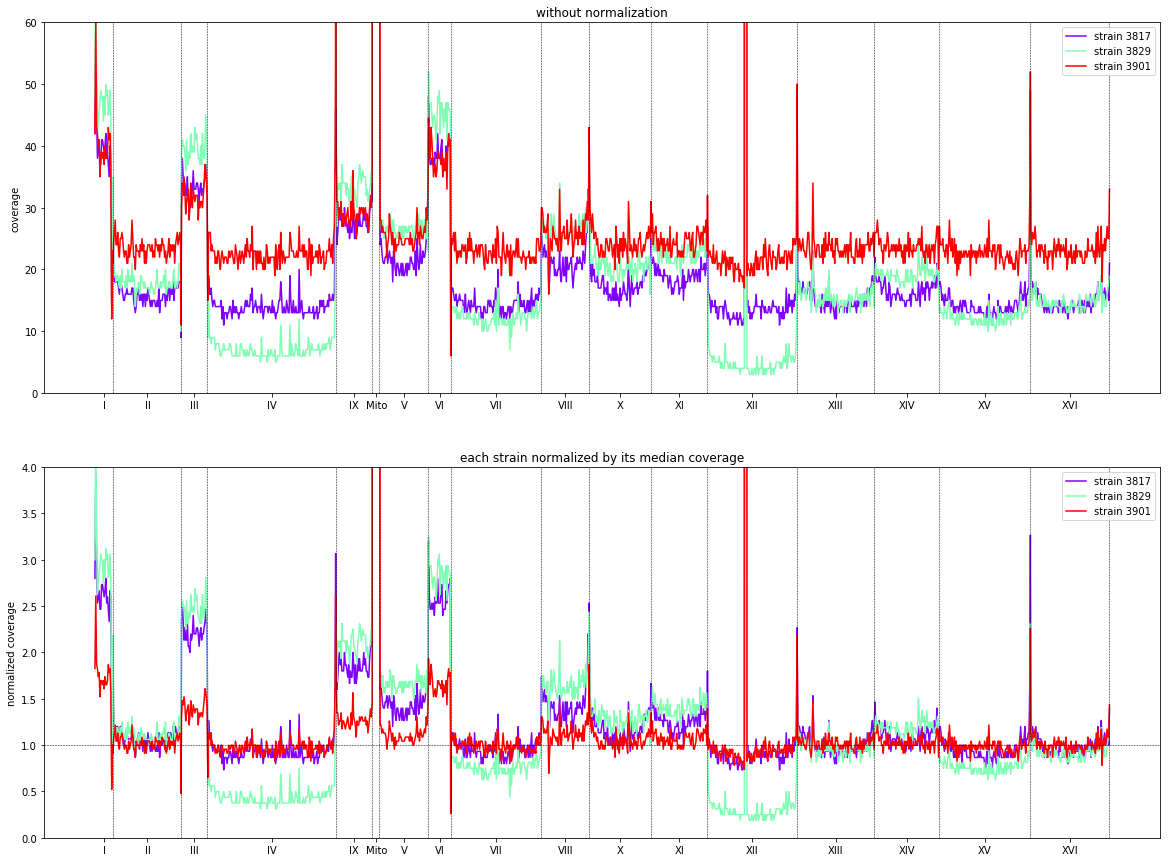

In [28]:
# plot absolute and normalized coverage
fig, ax = plt.subplots(2,1,figsize=(20,15))
labels = []
ticks = []
plot_strains = ['3817', '3829', '3901']

color=iter(cm.rainbow(np.linspace(0,1,len(plot_strains))))

df_plot = df[plot_strains]
df_plot_norm = df[plot_strains]/df[plot_strains].median(axis=0)

for s in plot_strains:
    c=next(color)
    ax[0].plot(df.pos, df_plot[s], linestyle='-',label='strain '+s, color=c)
    ax[1].plot(df.pos, df_plot_norm[s], linestyle='-',label='strain '+s, color=c)
    
for chr_i in df.chr.unique():
    pos_i = df.pos[df.chr==chr_i]
    labels.append(chr_i)
    ticks.append(np.median(pos_i))
    ax[0].axvline(x=np.max(pos_i), linestyle='--', color='k', linewidth=0.5)
    ax[1].axvline(x=np.max(pos_i), linestyle='--', color='k', linewidth=0.5)    

ax[1].axhline(y=1, linestyle='--', color='k', linewidth=0.5) 
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(labels)

ax[0].set_ylim([0,60])
ax[0].set_title('without normalization')
ax[0].set_ylabel('coverage')
ax[0].legend(loc=0)
ax[1].set_ylim([0,4])
ax[1].set_title('each strain normalized by its median coverage')
ax[1].set_ylabel('normalized coverage')
ax[1].legend(loc=0)
plt.savefig('../figures/coverage3817_3829_3901.pdf')

In [35]:
# comparison of coverage for two different sequencings of strain 3911
ref_gen_path = '/Volumes/milano/sequencing/ref_genome/Saccharomyces_cerevisiae.R64-1-1.dna.toplevel.fa'
bam_novogene = '/Volumes/milano/sequencing/9311/novogene_9311.sorted.bam'
bam_old = '/Volumes/milano/sequencing/round2/3911.trimmed.bwa.bam'
df = get_coverage_from_bam([bam_novogene, bam_old], ref_gen_path, blocksize=10000)

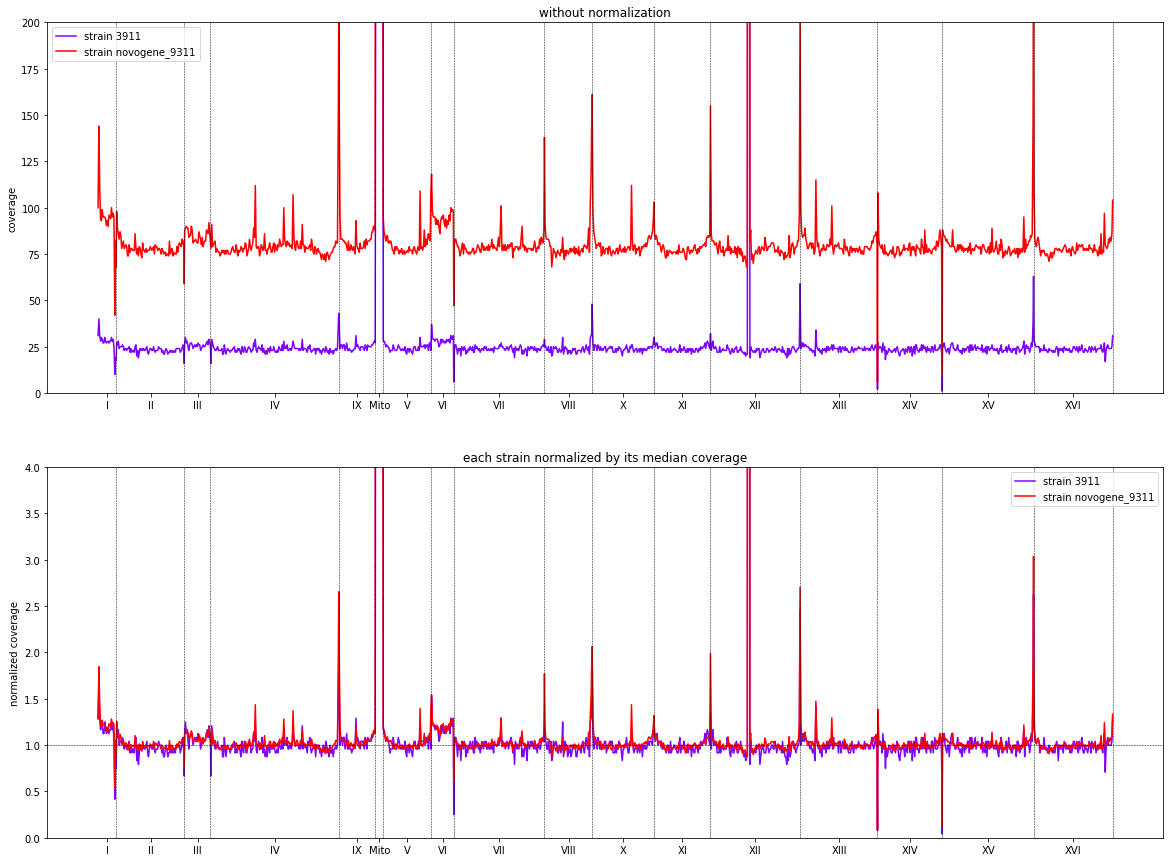

In [42]:
# plot absolute and normalized coverage
fig, ax = plt.subplots(2,1,figsize=(20,15))
labels = []
ticks = []
plot_strains = ['3911', 'novogene_9311']

color=iter(cm.rainbow(np.linspace(0,1,len(plot_strains))))

df_plot = df[plot_strains]
df_plot_norm = df[plot_strains]/df[plot_strains].median(axis=0)

for s in plot_strains:
    c=next(color)
    ax[0].plot(df.pos, df_plot[s], linestyle='-',label='strain '+s, color=c)
    ax[1].plot(df.pos, df_plot_norm[s], linestyle='-',label='strain '+s, color=c)
    
for chr_i in df.chr.unique():
    pos_i = df.pos[df.chr==chr_i]
    labels.append(chr_i)
    ticks.append(np.median(pos_i))
    ax[0].axvline(x=np.max(pos_i), linestyle='--', color='k', linewidth=0.5)
    ax[1].axvline(x=np.max(pos_i), linestyle='--', color='k', linewidth=0.5)    

ax[1].axhline(y=1, linestyle='--', color='k', linewidth=0.5) 
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(labels)
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(labels)

ax[0].set_ylim([0,200])
ax[0].set_title('without normalization')
ax[0].set_ylabel('coverage')
ax[0].legend(loc=0)
ax[1].set_ylim([0,4])
ax[1].set_title('each strain normalized by its median coverage')
ax[1].set_ylabel('normalized coverage')
ax[1].legend(loc=0)
plt.savefig('../figures/coverage3911_novogene_comparison.pdf')

In [34]:
cmd

'samtools mpileup -B -Q 30 -f /Volumes/milano/sequencing/ref_genome/Saccharomyces_cerevisiae.R64-1-1.dna.toplevel.fa /Volumes/milano/sequencing/9311/novogene_9311.bam /Volumes/milano/sequencing/round2/3911.trimmed.bwa.bam'